# Example 1: simple linear polymers
Here, we demonstrate the basic polymerist workflow which allows one to go from monomers and knowledge of  
a polymerization mechanism to complete polymer structure files in just a handful of cells!

To start, we'll look at the classic nylon-6,6 synthesis

## Output config
This initial config is just to clarify logging and depiction of molecules at each step; in production scripts, this can be omitted

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define your polymer ensemble

### 1a) Define chemically-complete monomer "feedstocks"
This is as simple as providing SMILES string for each monomer; the names are optional, but helpful for identifying fragments later on in the build step

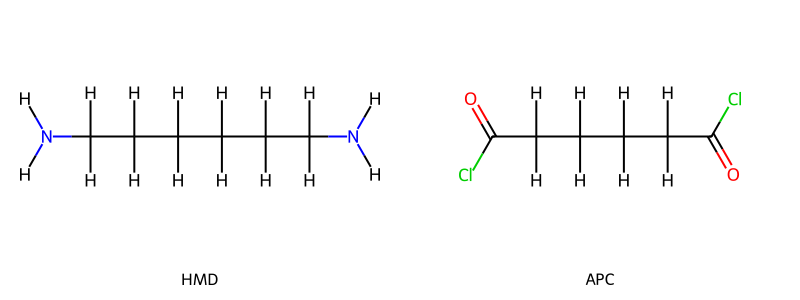

In [2]:
from rdkit.Chem.rdchem import Mol
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'HMD' : 'NCCCCCCN',           # hexamethylene diamine
    'APC' : 'ClC(=O)CCCCC(=O)Cl', # adipoyl chloride
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=monomers.keys())

### 1b) Define reaction template for polymerization reaction
The formalism employed is to think of a reaction as a rearrangement of atoms between active functional groups  
This frees us from needing to think about any _particular_ system for generating repeat units, and covers an entire chemical class with just one template!

#### Assemble reaction from target functional groups (in this case an amide and an acyl chloride)
"*" sites (called "linkers") are used to indicated a generic, unspecified neighboring residue  
Wherever you see them in a reaction, think of them as R-groups when defining a functional group template

Also, byproduct templates can be provided (HCl in the below examples) to match and "delete" reactions sideproducts which should be removed

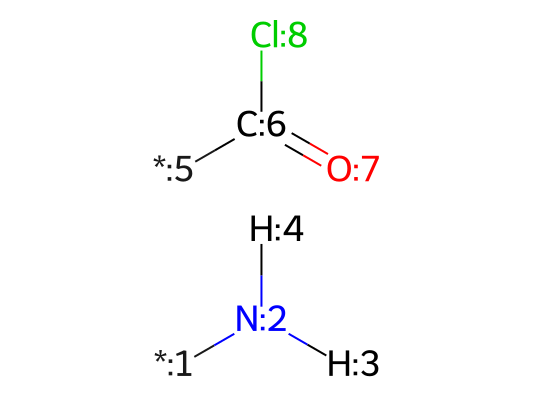

In [3]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolToSmiles
from polymerist.rdutils.reactions import ReactionAssembler


assem = ReactionAssembler(
    reactive_groups=[
        MolFromSmarts('*-N(-[H])(-[H])'), # amine group
        MolFromSmarts('*-C(=O)-Cl'),      # acyl chloride group
    ],
    byproducts=[MolFromSmarts('[H]-[Cl]')], # eject and unmap HCl byproduct
    rxn_name='amide-acyl chloride condensation',
)
display(assem.reactants)

#### Define reaction via rearrangement of active atoms
Atomic rearrangements are thought of as closed "cycles" of bonds which swap terminal atom; this is valid since bonds and atoms are initially always conserved  
To define these, it is only necessary to specify the movements of "active" atoms which change during the reaction as a [derangement](https://en.wikipedia.org/wiki/Derangement) (i.e. a permutation with no fixed points)

Each line of this dictionary notated a mobile bond in the format:
```python
assem.bond_derangement = {
    <start atom index> : (<neighbor before rxn index>, <neighbor after rxn index>),
    ...
}
```
Closure of cycles can be checked by inspection by seeing that the "columns" of before and after negihbors contain the same indices

Atom indices given should match the arbitrarily-assigned atoms numbering depicted above (though can be manually supplied in the defining SMARTS if necessary)   
It is worth noting that this is the **ONLY** place one has to do any "index-chasing" in this entire workflow; for the most part, everything is chemically-driven


INFO:polymerist.rdutils.bonding.permutation:4 --x-> 2


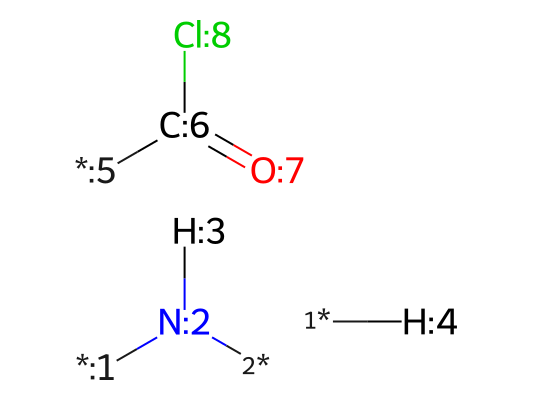

INFO:polymerist.rdutils.bonding.permutation:6 --x-> 8


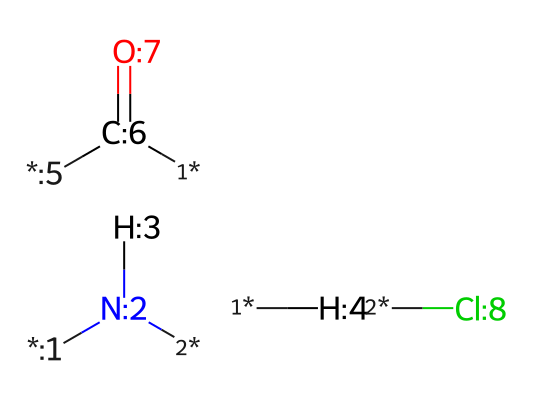

INFO:polymerist.rdutils.bonding.permutation:4 ----> 8


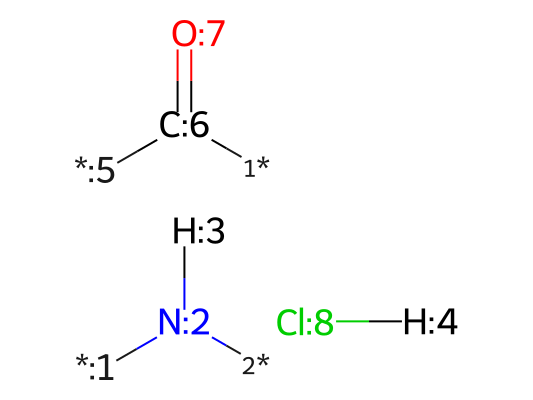

INFO:polymerist.rdutils.bonding.permutation:6 ----> 2


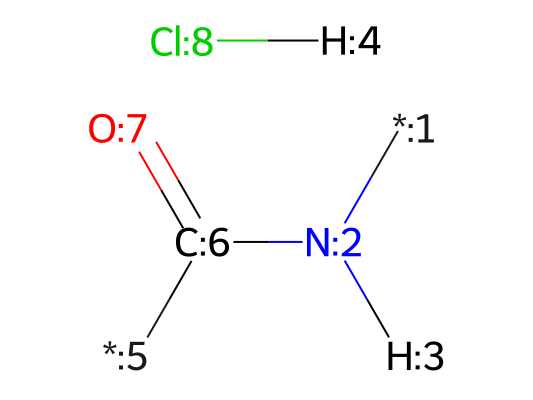

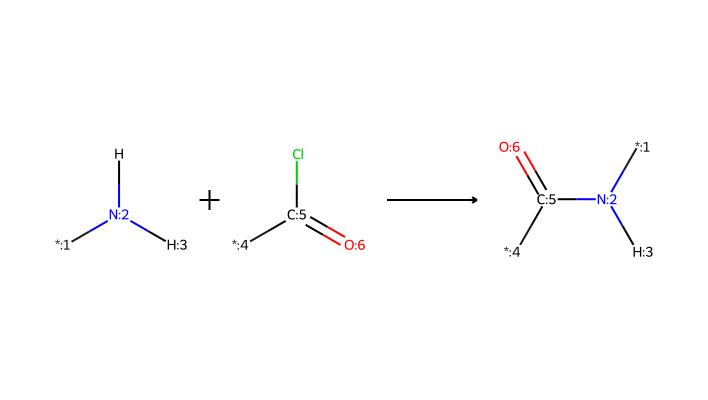

In [4]:
assem.bond_derangement = {
    4 : (2, 8), # H:4, which was connected to C:2, should reconnect to Cl:8
    6 : (8, 2), # C:6, which was connected to Cl:8, should reconnect to C:2
} # note that this forms a closed bond cycle, since atoms 2 and 8 each gain and lose 1 bond, respectively, amounting to no net valence change

rxn = assem.assemble_rxn(show_steps=True)
rxn_smarts = rxn.to_smarts()
display(rxn)

Notice above that the HCl identified as a byproduct is deleted from the products, and its constituent atoms are unmapped in the reactants

#### Export reaction for re-use
As mentioned, the above reaction-template definition is a one-time process; the same template will handle any other   
amide-acyl chloride polyamide just as well (which we'll see in the MPD-TMC demo)

We therefore export out reaction to resue later, to avoid needing to redo the setup above elsewhere

In [5]:
from polymerist.genutils.fileutils import assemble_path


rxn_smarts = rxn.to_smarts()
rxn_path = assemble_path('rxn_demo_files/rxns', prefix=rxn.rxnname, extension='rxn')
rxn_path.parent.mkdir(exist_ok=True, parents=True)
rxn.to_rxnfile(rxn_path)

## Enumerate all possible repeat unit fragments from monomers and reaction template
Now that we've defined monomers and a polymerization mechanism, the real fun begins!  

Here, polymerist uses these inputs to enumerate *EVERY* possible repeat unit that could be formed by these monomers interacting according to the defined mechanism,  
_exactly_ as they appear atom-by-atom. Intermonomer bonds are indicated by the aforementioned linker ("*") atoms

These fragments in turn define an ensemble of possible polymers structures; every polymer made from  
these starting products can be assembled from these fragments by "gluing together" along linker sites

Note that the initial monomers are also included in this set, as unreacted monomers are perfectly valid molecule in such a molecular system

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


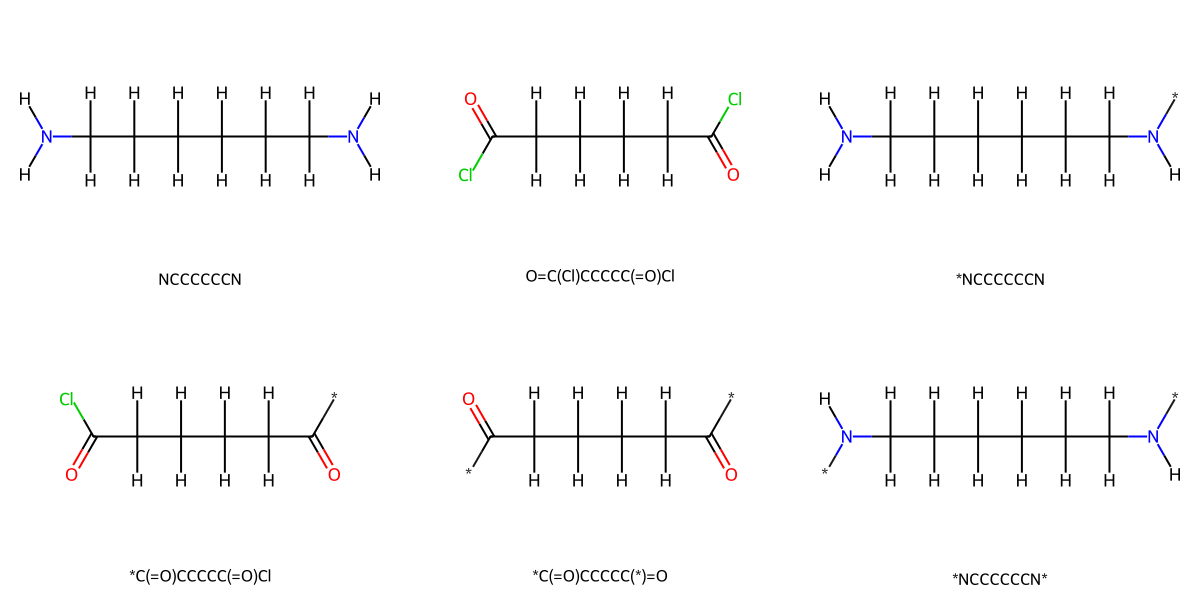

In [6]:
from polymerist.rdutils.reactions import AnnotatedReaction, PolymerizationReactor


reactor = PolymerizationReactor(rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts))
fragments = reactor.propagate_pooled(
    monomers.values(),
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(fragments.values(), molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=fragments.keys())

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment
For assembly, and in particular, to aid in OpenFF compatibility for MD export down the line, we encode non-monomer repeat unit fragments in the SMARTs superset specified in our [earlier manuscript](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01691)

From your point of view, you don't need to handle
Each distinct residue must be given a distinct name; these can in principle be arbitrary,  
but in practice should include some indication of the functionality (i.e. number of linker sites), which is assigned automatically here

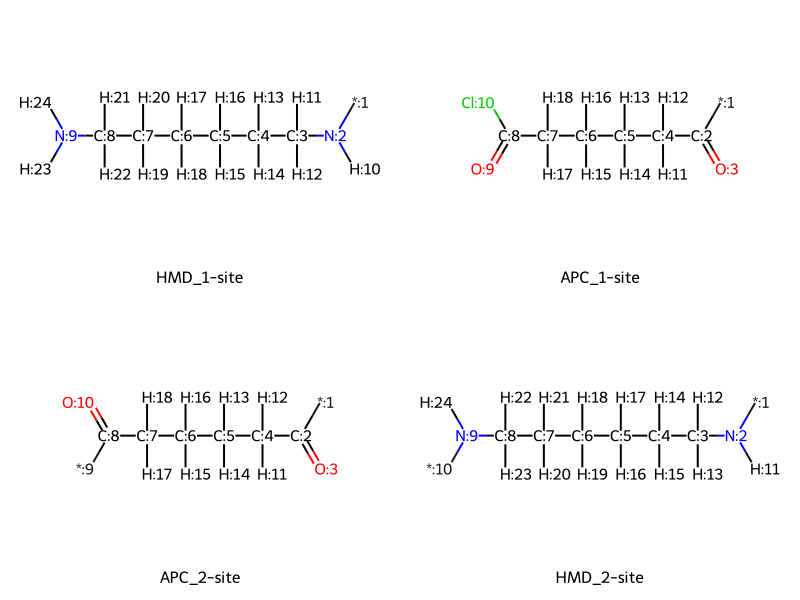

In [7]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_mol = MolFromSmarts(canon_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

## Use fragments to assemble a polymer
To tie everything together, we can pass these fragments to polymerist's built-in linear polymer builder to generate a polymer structure  

To the build, one supplies the fragments (with head-tail end group orientation defined), the sequence of middle monomers,  
and the desired number of repeat units in the chian (including end groups)

NOTE: unless you explicitly provide term group orientations, the builder will automatically choose the first two terminal groups  
as head and tail, respectively, in whatever order they appear, or the only terminal group twice if just one is provided

In [8]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 100
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : 'HMD_1-site',
    'tail' : 'APC_1-site',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='AB', # will alternate APC and HMD middle monomers ("A" refers to the first non-terminal monomer, "B" to the second, etc.)
    n_monomers=n_monomers,
    energy_minimize=do_energy_min, # disabling this will make structure generation much faster but give less physical structures
)
chain.visualize()

[12:30:04] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'HMD_1-site', 'tail': 'APC_1-site'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "AB" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 49 whole 2-sequence repeat(s), namely with the sequence [HMD_1-site] + 49*[AB] + [APC_1-site]
INFO:polymerist.polymers.building.linear:Registering middle monomer APC_2-site (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering middle monomer HMD_2-site (block identifier "B")
INFO:polymerist.polymers.building.linear:Registering terminal monomer HMD_1-site (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer APC_1-site (orientation "tail")
INFO:polymerist.polymers.building.linear:Assembling linear 100-mer chain (estimated 1902 atoms)
INFO:polymeris

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Export polymer structure files

In [9]:
from pathlib import Path

structures_dir = Path('rxn_demo_files/structures/nylon')
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to Structured Data (SD) File
This is the recommended format for all molecule structure files, both for polymerist operations and more generally,  
as it preserves chemical information losslessly and supports encoding of arbitrary metadata

In [10]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix='nylon', postfix=f'{n_monomers}mer', extension='sdf')
with SDWriter(sdf_path) as writer:
    writer.write(mbmol_to_rdmol(chain))

### Export to Protein DataBank (PDB) File
PDB export is supported due to its common useage, though altogether not recommended as it is a highly lossy and chemically non-explicit format

In [11]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix='nylon', postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc
As with reactions templates (and basically everything else in polymerist), you can serialize MonomerGroup objects to avoid needing to remake them more than once

In [12]:
fragments_path = assemble_path('rxn_demo_files/fragments', prefix='nylon', extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)